In [1]:
import os, random, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import nibabel as nib
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import wandb
from itertools import product
from datetime import datetime

# wandb 共通設定
WANDB_PROJECT = "vertebrae-augmentation_axial_learning_1"
wandb.login()                     # API キーは環境変数でも可

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yuya00 (yuya00-university-of-hyogo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# 学習モデル

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
# %%
# 1. データセットクラス (CTDataset)
##############################################
class CTDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row["FullPath"]
        # CSVの列名が "Fracture_label" の場合
        # (もし "Fracture_Label" や別名であれば修正してください)
        label = row["Fracture_Label"]

        # ----- 画像読み込み (NIfTI) -----
        nifti_obj = nib.load(img_path)
        img_arr = nifti_obj.get_fdata()

        # 3次元の場合は最初のスライスを使う（軸が違うなら適宜変更）
        if len(img_arr.shape) == 3:
            img_arr = img_arr[:, :, 0]
        elif len(img_arr.shape) != 2:
            raise ValueError(f"Unsupported image shape: {img_arr.shape}")

        # ----- HUウィンドウ (100～2000) 例 -----
        img_arr = np.clip(img_arr, 100, 2000)
        img_arr = (img_arr - 100) / (2000 - 100)  # 0～1 スケーリング
        img_arr = np.uint8(img_arr * 255)

        pil_img = Image.fromarray(img_arr).convert("L")

        if self.transform:
            pil_img = self.transform(pil_img)

        return pil_img, float(label)

# 2. モデル定義 (ModifiedResNet)
##############################################
class ModifiedResNet(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # 1ch入力に変更
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # 出力層を差し替え → 1ユニット (Sigmoid)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x


# 4. 検証関数 (evaluate_model)
##############################################
def evaluate_model(model, val_loader, criterion, device="cuda"):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            outputs = model(images).squeeze()  # shape: (batch,)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = running_loss / len(val_loader)

    # Precision-Recall
    precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)
    prauc = auc(recall, precision)

    # F1最大となる閾値を検索
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]

    return avg_loss, prauc, best_threshold, best_precision, best_recall




In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler=None, num_epochs=20, device="cuda"):
    run = wandb.init(project=WANDB_PROJECT, reinit=True,
                     config=dict(
                         epochs=num_epochs,
                         lr=optimizer.param_groups[0]["lr"],
                         weight_decay=optimizer.param_groups[0]["weight_decay"],
                         dropout=getattr(model.resnet.fc[0], "p", None)
                     ))
    wandb.watch(model, log="all", log_freq=100)

    best_prauc = 0.0
    for epoch in range(num_epochs):
        # ----- Training -----
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"[Train] {epoch+1}/{num_epochs}"):
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # ----- Validation -----
        val_loss, val_prauc, th, prec, rec = evaluate_model(model, val_loader, criterion, device)

        # wandb ログ
        wandb.log({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss":   val_loss,
            "val_prauc":  val_prauc,
            "best_th":    th,
            "precision":  prec,
            "recall":     rec,
            "lr": optimizer.param_groups[0]["lr"]
        })

        # scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # モデル保存
        if val_prauc > best_prauc:
            best_prauc = val_prauc
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # 例: 20250414_113045
            model_path = f"best_model_{timestamp}.pth"
            torch.save(model.state_dict(), model_path)
            wandb.run.summary["best_prauc"] = best_prauc
            wandb.run.summary["best_epoch"] = epoch+1
            wandb.run.summary["saved_model_path"] = model_path

            #使わない
            #torch.save(model.state_dict(), "best_model.pth")
            #wandb.run.summary["best_prauc"] = best_prauc
            #wandb.run.summary["best_epoch"] = epoch+1

    wandb.finish()
    return best_prauc


def grid_search(train_loader, val_loader, device="cuda"):
    num_epochs_list   = [20, 30]
    lr_list           = [1e-5, 3e-5]
    weight_decay_list = [1e-3, 1e-2]
    dropout_rate_list = [0.3, 0.0]

    for (num_epochs, lr, wd, do) in product(num_epochs_list, lr_list, weight_decay_list, dropout_rate_list):
        model = ModifiedResNet(dropout_rate=do).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
        best_prauc = train_model(model, train_loader, val_loader, criterion, optimizer,
                                 scheduler=scheduler, num_epochs=num_epochs, device=device)
        print(f"Finished: Ep{num_epochs} LR{lr} WD{wd} DO{do} → PRAUC {best_prauc:.4f}")

In [7]:
##############################################
# 7. メイン関数 (main)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

    # ----- CSV 指定 -----
train_csv = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_train_augmentation/axial/augumentation_labels_axial.csv"
val_csv   = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_val/axial/val_labels_axial.csv"

    # ----- Data Augmentation -----
transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # グレースケールの正規化
    ])
transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    # ----- Dataset & DataLoader -----
batch_size = 64
train_dataset = CTDataset(train_csv, transform=transform_train)
val_dataset   = CTDataset(val_csv,   transform=transform_val)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)

    # ----- グリッドサーチでベストモデル探索 -----
grid_search(train_loader, val_loader, device=device)

Using device: cuda


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[Train] 1/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/20:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▅▄▆▅▅▃▂██▃▅▁▃▃▂▂▂▃▄▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,████████████▁▁▁▁▁▁▁▁
precision,▅▄▁▂▄▄▂█▆▃▄▂▇▅▃▄▄▇▆▄
recall,▄▃▅█▆▄▇▁▃▄▄▇▄▅▅▅▄▃▃▄
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▃▃▄▅▆█▇▇▆▇▆▆▇▆▇█▇▇
val_prauc,▅▁▁▆▇▄▅▁▃▅▄▆█▇▆▇▆▆▆▆
best_epoch,13
best_prauc,0.4068
best_th,0.12116


Finished: Ep20 LR1e-05 WD0.001 DO0.3 → PRAUC 0.4068


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/20:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▃▄▅▆▁▆▃▅▃▃▆▇▆▅▆█▆▆█▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,████████████▁▁▁▁▁▁▁▁
precision,▂▁▃▃▂▃▃▄▂▄▃▆▆▆▆▆▆▇▇█
recall,▆▆▆▅█▅▄█▅▇▇▁▃▂▂▃▄▂▂▁
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▂▄▄▅▆▅▆▆▇▆▇▇▇▇▇▇██
val_prauc,▂▁▄▄▃▅▃█▄▅▄▃▆▄▅▅▅▅▆▅
best_epoch,8
best_prauc,0.48072
best_th,0.63452


Finished: Ep20 LR1e-05 WD0.001 DO0.0 → PRAUC 0.4807


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/20:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▄▄▄▁▅▃▂▃▆▅▂▇▄▆▄▆▃█▅▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,████████████▁▁▁▁▁▁▁▁
precision,▄▂▆▄▅▁▃▃▆█▃▂▅█▅▇▅▇▆▆
recall,▄▇▅█▂▅▃▂▂▁▃▂▃▁▂▁▂▁▂▂
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▁▄▃▅▇▇▇▅▆▇▆▆▇▇▇█▇▇
val_prauc,▅▅██▅▅▄▃▃▅▄▁▅▅▅▅▅▄▄▅
best_epoch,4
best_prauc,0.44054
best_th,0.68267


Finished: Ep20 LR1e-05 WD0.01 DO0.3 → PRAUC 0.4405


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/20:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▃▂▃▃▃▆▅▁▆▄▅█▅▃▃▅▅▃▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,████████████▁▁▁▁▁▁▁▁
precision,▁▄▂▃▅▂▂▄▄▄▄▂█▆▇▇█▇▅▄
recall,█▃▇▅▂▃▇▅▃▃▆▁▃▄▃▃▄▃▅▅
train_loss,█▄▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,▁▃▃▂▅▅▅▅▅▅▆█▆▅▆▅▆▅▅▇
val_prauc,▄▅▆▆▃▄▆▇▄▅▇▁▆▇▇██▇█▇
best_epoch,19
best_prauc,0.43534
best_th,0.17859


Finished: Ep20 LR1e-05 WD0.01 DO0.0 → PRAUC 0.4353


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/20:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▇▃█▁▂▆▂▅▂▃▂▅▅▂▄▂▁▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,████████████▁▁▁▁▁▁▁▁
precision,▅▃▃▂▁▆▃▅▃▁▅▄█▃▄▅▇▄▄▄
recall,▂█▆▇▆▄▅▆▇▁▆▅▃▆▆▆▇▇█▇
train_loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▁▁▃▅▅▄▆▄▄█▄▅▆▆▆▆▆▆▆▆
val_prauc,▄▇▅▆▅▅▅▆▇▁▆▆▅▆▆▇█▆▇▇
best_epoch,17
best_prauc,0.47864
best_th,0.11842


Finished: Ep20 LR3e-05 WD0.001 DO0.3 → PRAUC 0.4786


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/20:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▂▁▃▂▂▆▄█▅▂▄▂▁▂▁▁▁▁▁▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,████████████▁▁▁▁▁▁▁▁
precision,▃▄▄▃▁███▄▁▄▄▄▅▄▂▃▅▃▆
recall,▄▅▅▄▅▂▅▁▄█▅▇▆▅▆▆▆▅▆▄
train_loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▁▄▁▅▆▄▅▆▆▅▆▅▆▆▆█▇▇▇▇
val_prauc,▃▅▆▄▂▅█▁▃▂▅▆▇▅▆▄▆▅▅▆
best_epoch,7
best_prauc,0.50759
best_th,0.10031


Finished: Ep20 LR3e-05 WD0.001 DO0.0 → PRAUC 0.5076


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/20:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▆▅██▇▄▅▂▆▁▄▇▇▁▆▃▃██▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▃▅▃▅▄▄▄▅▆▇█▄▄▃▅▅▆▄▁▃
recall,▃▄▅▄▁▆▆▄▄▅▃▂▃▇▅▅▁▄█▄
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▄▄▃▂▁▄▁▂▄▅▄▃▂▂▃▄█▄
val_prauc,▂▄▄▃▂▅▆▅▅█▅▁▂▅▅▅▁▃▃▅
best_epoch,10
best_prauc,0.49088
best_th,0.04487


Finished: Ep20 LR3e-05 WD0.01 DO0.3 → PRAUC 0.4909


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/20:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/20:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▄▂▅▅▁▇█▂▁▁▅▂▂▁▁▄▃▂▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,████████████▁▁▁▁▁▁▁▁
precision,▄▂▅▂▁▇█▁▁▂▆▃▄▃▂▄▅▃▄▄
recall,▂█▃▄▄▃▂▅▁▂▄▄▃▅▆▂▄▃▃▃
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▅▂▅▅█▅▂▄▄▅▅▅▄▅▅▅
val_prauc,▄▅▄▃▂█▆▂▁▃▆▃▄▄▃▃▅▂▄▄
best_epoch,6
best_prauc,0.50374
best_th,0.05669


Finished: Ep20 LR3e-05 WD0.01 DO0.0 → PRAUC 0.5037


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 21/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 22/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 23/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 24/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 25/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 26/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 27/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 28/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 29/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 30/30:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▃▆▄▃▅▃▅▄▃▆▂█▁▁▄▁▂▂▄▂▂▅▂▃▃▂▄▃▃▄
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
precision,▆▆▅▁▆▆▄▆▂▅▂█▃▂▅▂▃▃▄▄▃▆▃▄▄▄▆▄▃▄
recall,█▄▅▇▅▃▅▂▅▃▂▁▅▆▂▆▄▄▂▃▄▂▄▃▃▃▂▃▃▃
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▂▄▄▅▅▇▆▆▇▆▇▇▇▇▇▇▇▇██████▇█▇█
val_prauc,█▅▆▃▅▄▃▂▂▃▁▄▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃
best_epoch,1
best_prauc,0.45583
best_th,0.37989


Finished: Ep30 LR1e-05 WD0.001 DO0.3 → PRAUC 0.4558


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 21/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 22/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 23/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 24/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 25/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 26/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 27/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 28/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 29/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 30/30:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▃▃█▅▄▃▃▁▂▅▃▃▂▆▂▄▃▂▁▁▂▂▁▄▃▃▄▄▆▃
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
precision,▁▂▇▄▃▄▇▅▅▅█▅▆█▅▆▇▆▄▄▅▄▅▇▇▇█▇█▇
recall,█▆▁▅▄▃▂▃▅▃▂▅▅▄▅▄▄▅▇▆▆▆▆▄▄▃▃▃▃▄
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▂▃▄▅▆▇▆▆▆▆▆▆▇▆▇▇▆▇▇▇▇▇▇██▇▇▇
val_prauc,▁▃▃▃▂▄▃▄▆▃▅▇██▇▇▆▇▇▆▆▆▇▆▆▆▆▆▆▆
best_epoch,14
best_prauc,0.41741
best_th,0.20999


Finished: Ep30 LR1e-05 WD0.001 DO0.0 → PRAUC 0.4174


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 21/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 22/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 23/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 24/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 25/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 26/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 27/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 28/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 29/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 30/30:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▅▅▆▄▃▃▄▂█▂▁▂▄▃▇▄▅▅▃▃▄▅▂▄▂▃▄▃▃▃
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,█████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
precision,▁▄▃▂▄▂▄▂▂▃▃▃▆▄█▆▇▄▅▅▄▇▄▄▄▅▅▅▅▅
recall,▄▄▃▁▅▇▁▃▄█▇▂▃▅▂▃▃▄▅▄▅▂▄▅▅▄▄▄▄▃
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▂▄▄▅▆▆▆▆▅█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇
val_prauc,▁▆▅▂▆▅▂▂▃▇▆▂▇█▇▇▆▇█▇▇▆▆▇▇▆▆▆▆▆
best_epoch,19
best_prauc,0.39599
best_th,0.25693


Finished: Ep30 LR1e-05 WD0.01 DO0.3 → PRAUC 0.3960


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 21/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 22/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 23/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 24/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 25/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 26/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 27/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 28/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 29/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 30/30:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▃▂▃▃▂▂▅▁▁▅█▆▃▂▂▄▄▁▁▂▂▁▂▃▁▁▃▂▃▃
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
precision,▁▂▁▁▂▃▆▆▃▃█▅▅▄▃▃▆▄▂▃▄▄▄▄▃▃▅▅▅▅
recall,█▄▄█▆▁▁▅▃▅▃▂▃▃▇▄▂▄▄▇▄▃▄▄▆▆▃▃▃▃
train_loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▃▃▃▆▅█▆▆▅▅▄▆▅▆▆▆▆▆▇█▇▇▇▇▇▇▇▇
val_prauc,▂▁▂▃▄▁▃▆▃▄█▅▆▅▅▃▅▆▃▆▅▄▄▄▄▄▄▄▄▄
best_epoch,11
best_prauc,0.45035
best_th,0.31027


Finished: Ep30 LR1e-05 WD0.01 DO0.0 → PRAUC 0.4504


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 21/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 22/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 23/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 24/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 25/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 26/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 27/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 28/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 29/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 30/30:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▃▂▄▇▄▅▁▆▆█▄▃▂▂▅▃▆▅▇▆▆▅▄▄▆▆▅█▅▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
precision,▃▄▄▅▃▅▁▆▅▃▅▆▅▆▆▆▇█▇▇▇▇▆▅▆▆▆▇▅▆
recall,▄█▇▃▂▃▆▅▃▅▃▃▆▃▁▂▁▁▁▁▁▂▂▃▂▂▂▂▂▂
train_loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▂▃▅▄▄▄▆█▅▄▃▄▆▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆
val_prauc,▃██▆▁▅▁▆▄▄▅▆█▇▅▅▅▅▅▄▅▅▆▅▆▆▆▆▅▆
best_epoch,3
best_prauc,0.474
best_th,0.58478


Finished: Ep30 LR3e-05 WD0.001 DO0.3 → PRAUC 0.4740


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 21/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 22/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 23/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 24/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 25/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 26/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 27/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 28/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 29/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 30/30:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▃▂▂█▁▃█▃▃▁▂▁▃▃▄▂▃▄▅▃▁▂▂▃▂▆▄▄▆▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,█████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
precision,▂▄▁▇▂▃▅▄▆▃▄▁▆▅▆▄▄▆▇▇▄▆▆▇▇██▇██
recall,█▆▃▂▅▆▅▁▇▅▁▆▃▄▂▃▂▁▁▁▅▃▃▁▂▁▁▁▁▁
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▄▂▇▂▂▅▂▅▆▇▇▄▅▅▇█▆█▆▇▇▇█▇█▇▇▇
val_prauc,▄▇▁▆▂▅▇▃█▆▃▃▅▆▅▅▄▄▅▅▆▆▆▅▅▅▅▅▅▅
best_epoch,9
best_prauc,0.48878
best_th,0.54364


Finished: Ep30 LR3e-05 WD0.001 DO0.0 → PRAUC 0.4888


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 21/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 22/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 23/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 24/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 25/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 26/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 27/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 28/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 29/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 30/30:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▃▂█▄▃▂▄▂▅▅▆▄▆▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,██████████████████▂▂▂▂▂▂▂▂▂▂▂▁
precision,▃▄█▁▅▄▅▃▅▄▅▇▅▇▄▅▇▂▅▅▆▅▇▅▅▆▅▅▄▅
recall,▄▆▃▄▄▅▆▇▃▄▁▅▅▄▄▅▇█▆█▇▇▅▆▄▆▆▅▆▆
train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▃▇▅▅▁▄▄▆▇▅▃██▄▃▇▄▅▅▅▆▇█▆▆▇▆▇
val_prauc,▄▆▆▁▆▅▇▅▅▆▃▆▆▆▅▆█▅▇▇▇▇▇▆▅▇▆▆▅▆
best_epoch,17
best_prauc,0.49746
best_th,0.01702


Finished: Ep30 LR3e-05 WD0.01 DO0.3 → PRAUC 0.4975


/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Train] 1/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 2/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 3/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 4/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 5/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 6/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 7/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 8/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 9/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 10/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 11/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 12/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 13/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 14/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 15/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 16/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 17/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 18/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 19/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 20/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 21/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 22/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 23/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 24/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 25/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 26/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 27/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 28/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 29/30:   0%|          | 0/1036 [00:00<?, ?it/s]

[Train] 30/30:   0%|          | 0/1036 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_th,▂▂▇▂▄▅▄▂▁▁██▆▃▃▄▁▂▃▂▃▄▃▂▂▁▁▂▁▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,███████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
precision,▅▅▄▄▂▂▆▆▅▄█▆▁▂▃▄▂▄▅▃▆█▆▇▄▄▃▄▄▅
recall,▃▃▅▆▁▆▃▁▃▅▃▂▂▄█▆▇▇▆▆▄▃▄▄▄▅▆▆▆▅
train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▁▃▄▂▅▅▄▂▃█▂▂▂▄▃▃▅▃▃▃▃▄▃▃▃▃▃
val_prauc,▆▇▆█▃▃▅▄▆▇▇▅▁▄▇▇▆█▇▅▇▇▆█▆▆▆▇▆▇
best_epoch,24
best_prauc,0.44112
best_th,0.12574


Finished: Ep30 LR3e-05 WD0.01 DO0.0 → PRAUC 0.4411


# 可視化

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1/30] Train 0.1168 | Val 0.2386 | PRAUC 0.4006
[2/30] Train 0.0502 | Val 0.3115 | PRAUC 0.3434
[3/30] Train 0.0369 | Val 0.3423 | PRAUC 0.3215
[4/30] Train 0.0317 | Val 0.3018 | PRAUC 0.3811
[5/30] Train 0.0282 | Val 0.4220 | PRAUC 0.3352
[6/30] Train 0.0266 | Val 0.3028 | PRAUC 0.3355
[7/30] Train 0.0258 | Val 0.3019 | PRAUC 0.3266
[8/30] Train 0.0253 | Val 0.3064 | PRAUC 0.3485
[9/30] Train 0.0229 | Val 0.3100 | PRAUC 0.3681
[10/30] Train 0.0247 | Val 0.4675 | PRAUC 0.2142
[11/30] Train 0.0222 | Val 0.3317 | PRAUC 0.3937
[12/30] Train 0.0231 | Val 0.2108 | PRAUC 0.5088
[13/30] Train 0.0211 | Val 0.2034 | PRAUC 0.5521
[14/30] Train 0.0220 | Val 0.2895 | PRAUC 0.4180
[15/30] Train 0.0215 | Val 0.2609 | PRAUC 0.4651
[16/30] Train 0.0199 | Val 0.3208 | PRAUC 0.4300
[17/30] Train 0.0194 | Val 0.2756 | PRAUC 0.3836
[18/30] Train 0.0183 | Val 0.2921 | PRAUC 0.4245
[19/30] Train 0.0188 | Val 0.5780 | PRAUC 0.1806
[20/30] Train 0.0184 | Val 0.2634 | PRAUC 0.4935
[21/30] Train 0.0169 | Val 0.

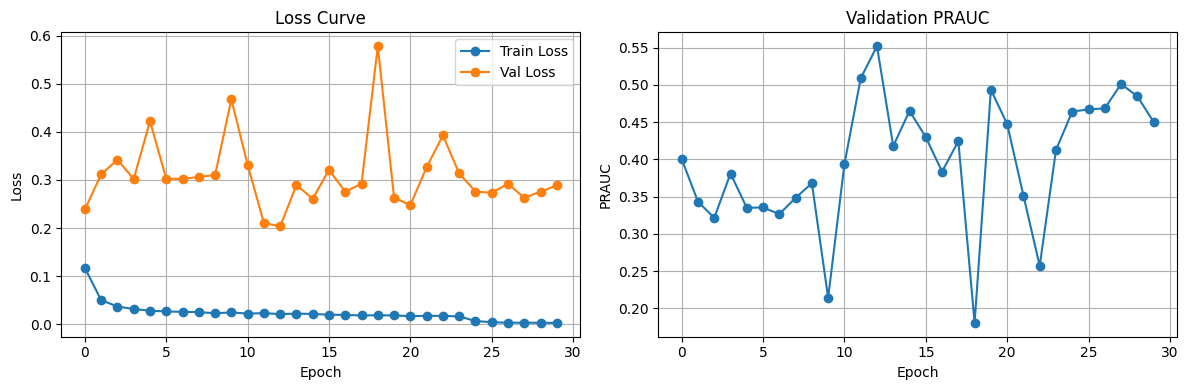

: 

In [ ]:
# ----- CSV 指定 -----
train_csv = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_train_augmentation/axial/augumentation_labels_axial.csv"
val_csv   = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_val/axial/val_labels_axial.csv"

    # ----- Data Augmentation -----
transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # グレースケールの正規化
    ])
transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

# ----- Dataset & DataLoader -----
batch_size = 64
train_dataset = CTDataset(train_csv, transform=transform_train)
val_dataset   = CTDataset(val_csv,   transform=transform_val)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)

# ---------- 1. ベストハイパラを手入力 (CSV を見て書き換え) ----------
best_num_epochs = 30
best_lr         = 3e-5
best_wd         = 1e-2
best_dropout    = 0.0

# ---------- 2. DataLoader の再利用 ----------
# train_loader, val_loader はすでに作ってある前提
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- 3. モデル・オプティマイザ ----------
model = ModifiedResNet(dropout_rate=best_dropout).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

# ---------- 4. 学習 (履歴を取りつつ) ----------
train_losses = []
val_losses   = []
val_praucs   = []

for epoch in range(best_num_epochs):
    # ---- Train ----
    model.train()
    running = 0.0
    for imgs, labels in train_loader:
        imgs   = imgs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        out = model(imgs).squeeze()
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running += loss.item()
    train_losses.append(running / len(train_loader))

    # ---- Val ----
    v_loss, v_prauc, *_ = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(v_loss)
    val_praucs.append(v_prauc)
    scheduler.step(v_loss)

    print(f"[{epoch+1}/{best_num_epochs}] Train {train_losses[-1]:.4f} | "
          f"Val {v_loss:.4f} | PRAUC {v_prauc:.4f}")

# ---------- 5. 可視化 ----------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax[0].plot(train_losses, label="Train Loss", marker='o')
ax[0].plot(val_losses,   label="Val Loss",   marker='o')
ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].set_title("Loss Curve")
ax[0].legend(); ax[0].grid(True)

# PRAUC
ax[1].plot(val_praucs, marker='o')
ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("PRAUC"); ax[1].set_title("Validation PRAUC")
ax[1].grid(True)

plt.tight_layout()
plt.show()


# 推論

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [ ]:
from PIL import Image
from sklearn.metrics import (precision_recall_curve, auc, roc_curve, 
                             accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)

In [ ]:
class CTDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        img_p = row["FullPath"]
        label = float(row["Fracture_Label"])

        img = nib.load(img_p).get_fdata()
        if img.ndim == 3:
            img = img[:, :, 0]
        img = np.clip(img, 100, 2000)
        img = np.uint8((img - 100)/(2000-100) * 255)
        pil = Image.fromarray(img).convert("L")

        if self.transform:
            pil = self.transform(pil)
        return pil, label
    
test_csv = "/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_test/axial/test_labels_axial.csv"

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_loader = DataLoader(
    CTDataset(test_csv, transform=transform_test),
    batch_size=64, shuffle=False, num_workers=4
)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ModifiedResNet(dropout_rate=0.0).to(device)   # dropout は学習時の値
model.load_state_dict(torch.load("S_best_model_grid_1.pth", map_location=device))
model.eval()

y_true, y_prob = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs   = imgs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)

        probs  = model(imgs).squeeze()        # 0–1 の確率
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

# ---------- PRAUC ----------
prec, rec, th = precision_recall_curve(y_true, y_prob)
prauc = auc(rec, prec)

# ---------- ROC AUC ----------
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# ---------- 最適閾値（F1 最大） ----------
f1s = 2*(prec*rec)/(prec+rec+1e-8)
best_idx = np.argmax(f1s)
best_th  = th[best_idx] if best_idx < len(th) else 0.5

# ---------- 2値化 ----------
y_pred = (y_prob >= best_th).astype(int)

# ---------- 各種指標 ----------
acc  = accuracy_score (y_true, y_pred)
prec_bin = precision_score(y_true, y_pred, zero_division=0)
rec_bin  = recall_score   (y_true, y_pred, zero_division=0)
f1   = f1_score       (y_true, y_pred, zero_division=0)
cm   = confusion_matrix(y_true, y_pred)

print(f"PRAUC         : {prauc:.4f}")
print(f"ROC AUC       : {roc_auc:.4f}")
print(f"Best Th (F1)  : {best_th:.3f}")
print(f"Accuracy      : {acc:.4f}")
print(f"Precision     : {prec_bin:.4f}")
print(f"Recall        : {rec_bin:.4f}")
print(f"F1            : {f1:.4f}")
print("Confusion Matrix\n", cm)

/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_3450384/1347469006.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpicklin

PRAUC         : 0.4881
ROC AUC       : 0.8217
Best Th (F1)  : 0.112
Accuracy      : 0.9241
Precision     : 0.5449
Recall        : 0.4437
F1            : 0.4892
Confusion Matrix
 [[11857   405]
 [  608   485]]


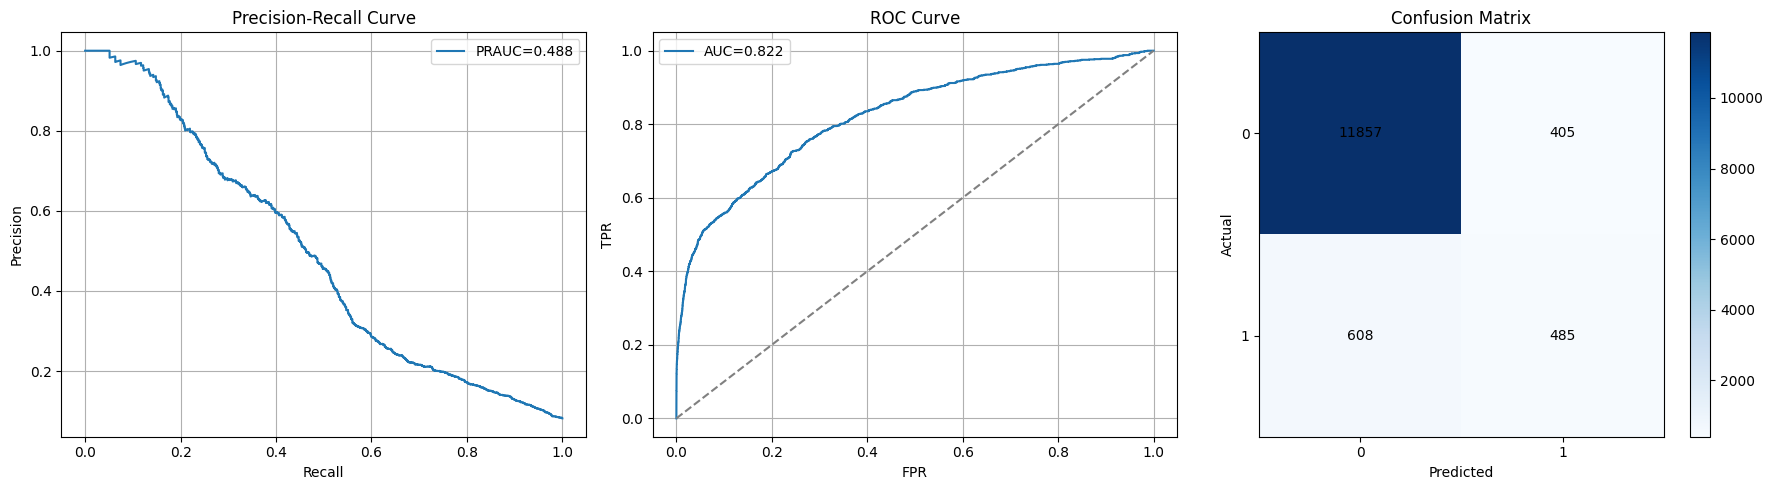

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

# PR Curve
ax[0].plot(rec, prec, label=f"PRAUC={prauc:.3f}")
ax[0].set_xlabel("Recall"); ax[0].set_ylabel("Precision")
ax[0].set_title("Precision-Recall Curve"); ax[0].grid(); ax[0].legend()

# ROC Curve
ax[1].plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
ax[1].plot([0,1],[0,1],'--',color='gray')
ax[1].set_xlabel("FPR"); ax[1].set_ylabel("TPR")
ax[1].set_title("ROC Curve"); ax[1].grid(); ax[1].legend()

# Confusion Matrix
im = ax[2].imshow(cm, cmap='Blues')
for i in range(2):
    for j in range(2):
        ax[2].text(j, i, cm[i, j], ha='center', va='center', color='black')
ax[2].set_xticks([0,1]); ax[2].set_yticks([0,1])
ax[2].set_xlabel("Predicted"); ax[2].set_ylabel("Actual")
ax[2].set_title("Confusion Matrix")
fig.colorbar(im, ax=ax[2])

plt.tight_layout(); plt.show()
